In [1]:
from new_tools import *
from tools import animate_trajectories
from importlib import reload
from tools import animate_trajectories_with_temp
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = generate_sequences(n_sequences=2000, T=30)  # adjust as you like
x_train = x_train.to(device)

model = DKF(x_dim=3, z_dim=4, h_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
n_epochs = 60

def get_batches(x, batch_size):
    N = x.size(0)
    idx = torch.randperm(N)
    for i in range(0, N, batch_size):
        yield x[idx[i:i+batch_size]]

for epoch in range(1, n_epochs+1):
    model.train()
    epoch_loss = 0.0
    n_batches = 0
    for batch in get_batches(x_train, batch_size):
        optimizer.zero_grad()
        loss, elbo = model(batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n_batches += 1
    print(f"Epoch {epoch:03d} | loss = {epoch_loss / n_batches:.4f}")


Epoch 001 | loss = 94137.8330
Epoch 002 | loss = 32258.3535
Epoch 003 | loss = 3835.3552
Epoch 004 | loss = 1182.4546
Epoch 005 | loss = 803.1394
Epoch 006 | loss = 688.2368
Epoch 007 | loss = 630.2775
Epoch 008 | loss = 592.1653
Epoch 009 | loss = 555.9269
Epoch 010 | loss = 508.1015
Epoch 011 | loss = 445.2867
Epoch 012 | loss = 391.4330
Epoch 013 | loss = 370.2448
Epoch 014 | loss = 360.6351
Epoch 015 | loss = 352.5545
Epoch 016 | loss = 348.5907
Epoch 017 | loss = 340.9997
Epoch 018 | loss = 334.5714
Epoch 019 | loss = 339.1775
Epoch 020 | loss = 329.7331
Epoch 021 | loss = 327.5923
Epoch 022 | loss = 322.6928
Epoch 023 | loss = 322.9583
Epoch 024 | loss = 322.7475
Epoch 025 | loss = 314.7954
Epoch 026 | loss = 312.3096
Epoch 027 | loss = 314.6704
Epoch 028 | loss = 304.4780
Epoch 029 | loss = 299.5730
Epoch 030 | loss = 299.7740
Epoch 031 | loss = 294.9137
Epoch 032 | loss = 298.7765
Epoch 033 | loss = 289.3679
Epoch 034 | loss = 287.4263
Epoch 035 | loss = 296.4788
Epoch 036 | lo

In [4]:
# Generate one test trajectory
sim = BouncingBallSim()
T_test = 60
obs_list = []
gt_list = []

for _ in range(T_test):
    obs, _, gt = sim.step()
    obs_list.append(obs)
    gt_list.append(gt)

observations = np.array(obs_list)   # (T, 2)
ground_truth = np.array(gt_list)    # (T, 2)

# Split for convenience
obs_pos = observations[:, :2]       # (T, 2) - for CKF
true_pos = ground_truth[:, :2]          # (T, 2)
true_T   = ground_truth[:, 4]           # (T,)


In [5]:
model.eval()
with torch.no_grad():
    x_test = torch.from_numpy(observations).float().unsqueeze(0).to(device)  # (1,T,3)
    z_mu = model.infer_posterior_mean(x_test)  # (T,4)
    z_mu_t = torch.from_numpy(z_mu).float().to(device)
    x_hat_t = model.decoder(z_mu_t)           # (T,3)
    dkf_pos_est = x_hat_t[:, :2].cpu().numpy()
    dkf_T_est  = x_hat_t[:, 2].cpu().numpy()
                # (T, 2)


In [6]:
# Create CKF with reasonable noise settings
ckf = ClassicalKF(
    dt=1.0,
    process_var_pos=1e-3,
    process_var_vel=1e-2,
    meas_var=5.0  # because your pos noise std ~ 0.5 => var ~ 0.25
)

# Initialize state using first observation
ckf.initial_state_mean = np.array([
    obs_pos[0, 0],  # x
    obs_pos[0, 1],  # y
    0.0,            # initial vx guess
    0.0             # initial vy guess
])
ckf.initial_state_covariance = np.eye(4) * 1.0

# Run the filter
ckf_means, ckf_covs = ckf.filter(obs_pos)  # (T,4), (T,4,4)

# Extract position estimates
ckf_pos_est = ckf_means[:, :2]  # (T,2)


In [7]:
html_anim = animate_trajectories_with_temp(
    ground_truth=true_pos,            # includes true pos (first 2 dims)
    estimates=[dkf_pos_est,ckf_pos_est],          # DKF pos recon
    labels=["DKF", "CKF"],
    true_temp=true_T,                 # true T over time
    est_temps=[dkf_T_est],            # DKF estimated T
    dt=0.02
)

html_anim  # in a notebook


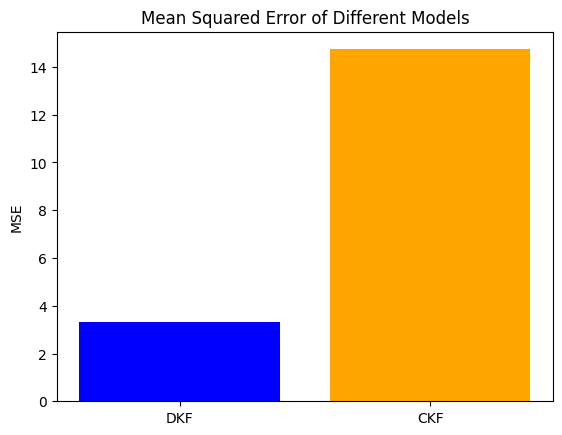

In [8]:
errors = {
    "DKF": np.linalg.norm(dkf_pos_est - true_pos),
    "CKF": np.linalg.norm(ckf_pos_est - true_pos)
}

plt.bar(errors.keys(), errors.values(), color=['blue', 'orange'])
plt.title("Mean Squared Error of Different Models")
plt.ylabel("MSE")
plt.show()